## Student Name: Nick Marshall

In [1]:
#import any required libraries
! conda install keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
import keras
from keras.models import Sequential
from keras.layers import Dense
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression



==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.



### Step 1 – Data Acquisition
Load the training data 'house_prices_train.csv' into a dataframe. Explore the data to get a better understanding of its structure and any data preparation steps that you need to perform.

In [2]:
#Load the data and view the dimensions

url      = 'house_prices_train.csv' #TODO: provide the url for the training data
data     = pd.read_csv(url)
data2 = pd.read_csv(url, keep_default_na = False)
data_dim = data.shape

print ('There are {} rows and {} columns.'.format(data_dim[0], data_dim[1]))

There are 1460 rows and 81 columns.


Lets view samples of the data

In [3]:
#view a few observations
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Use your intuition!
At first glance is there any field that, without a doubt, will not contribute to the predictions?

In [4]:
#TODO: remove/exclude the unnecessary field(s) that will not contribute towards the prediction
del data['Id']

In [5]:
#simple transformation: change MSSubClass to a categorical variable

data['MSSubClass'] = data['MSSubClass'].astype(str)

### Step 2 – Data Exploration
- Gather summary/descriptive statistics and inspect **all the fields**. This can help you to identify outliers and detect any inconsistencies
- View the frequency of missing values.

<ipython-input-6-ffc0efdbe593>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(column)


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

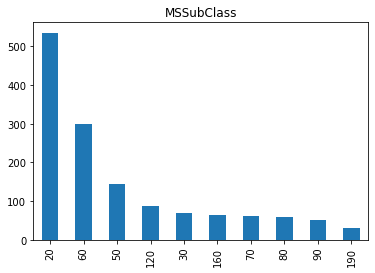

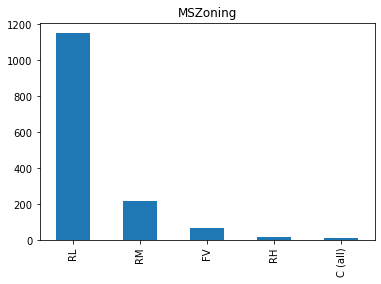

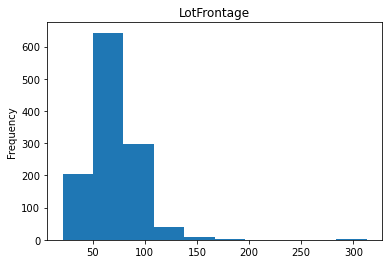

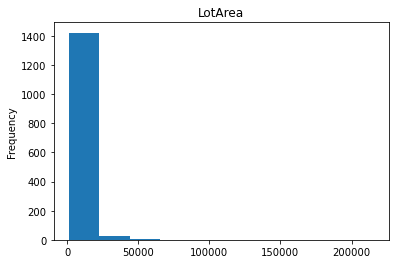

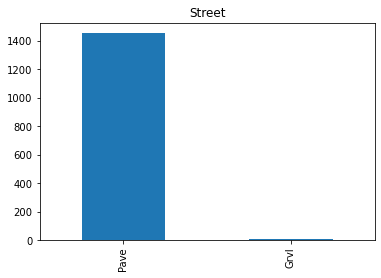

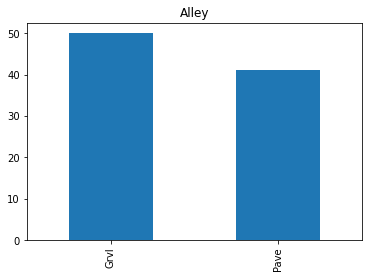

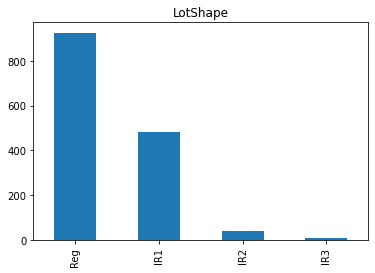

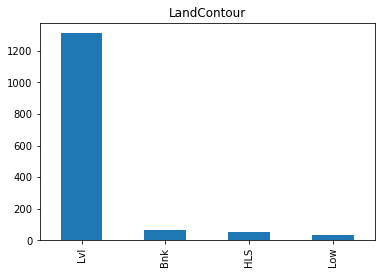

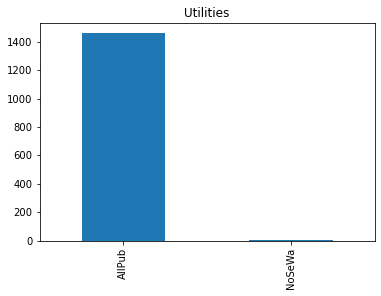

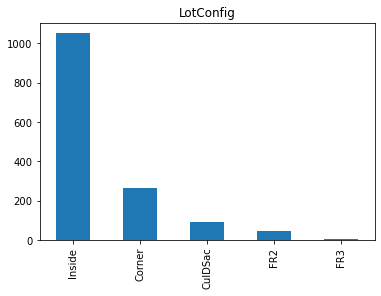

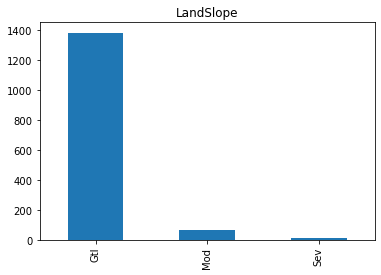

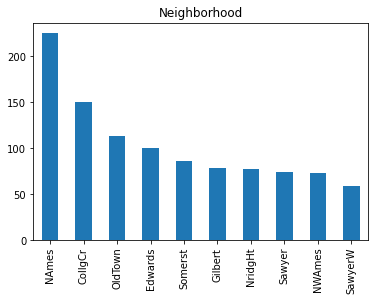

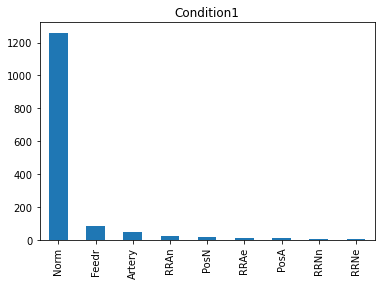

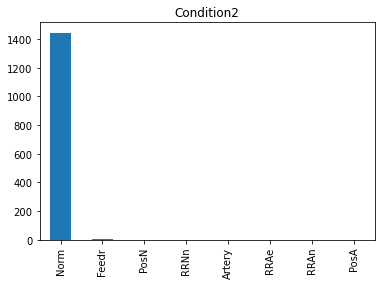

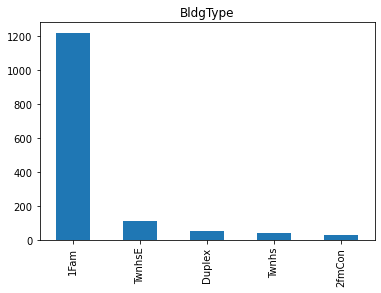

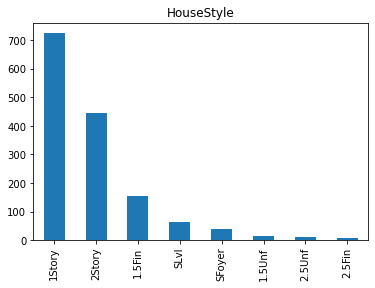

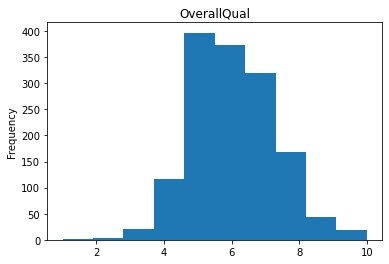

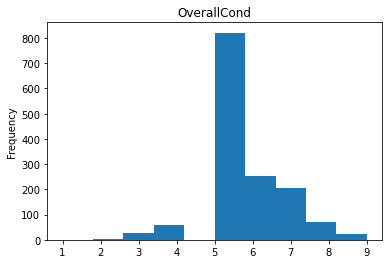

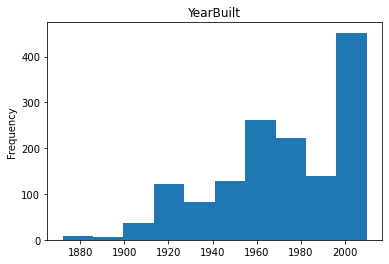

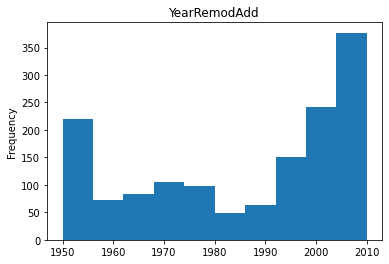

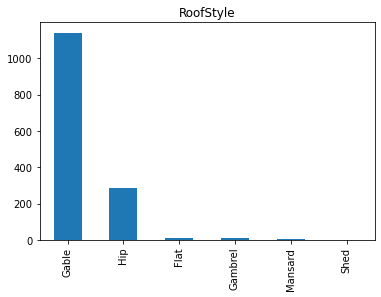

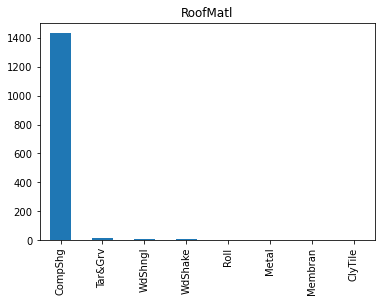

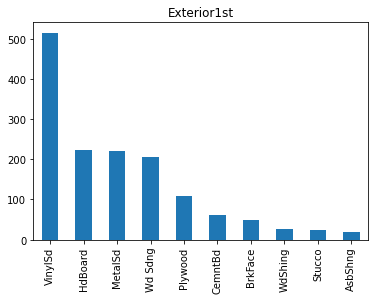

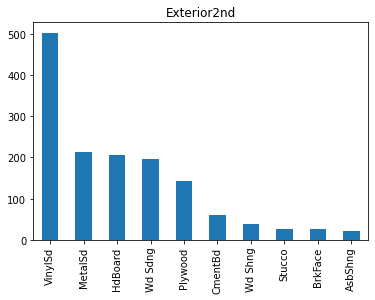

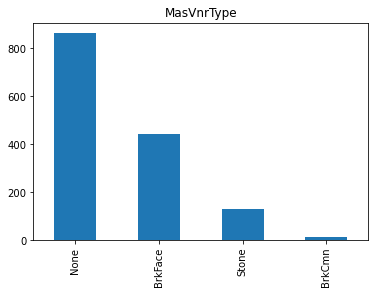

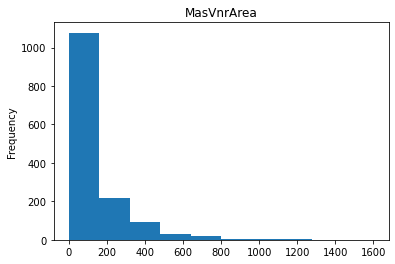

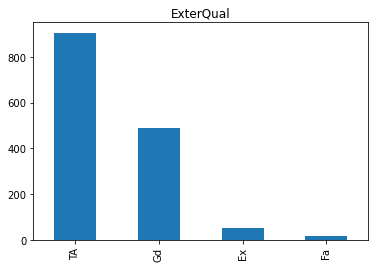

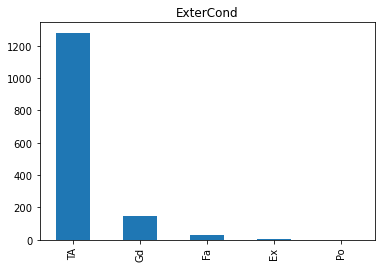

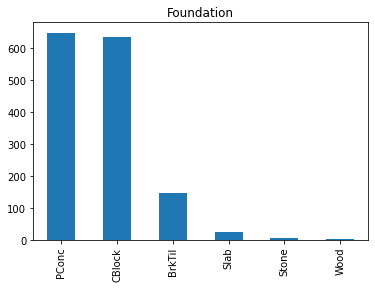

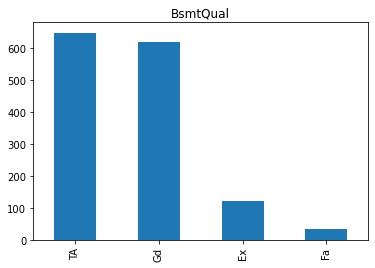

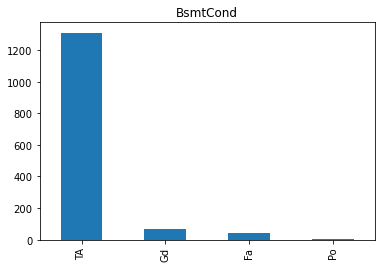

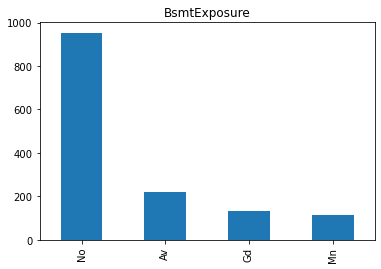

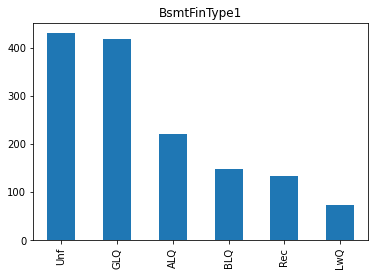

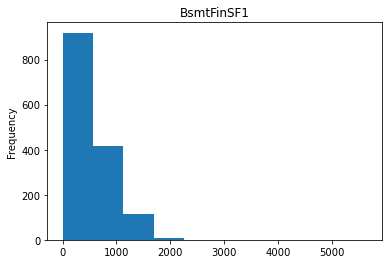

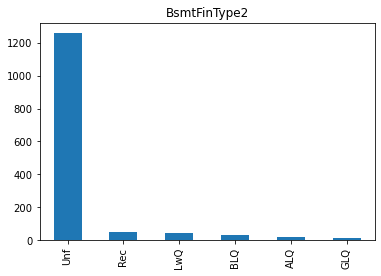

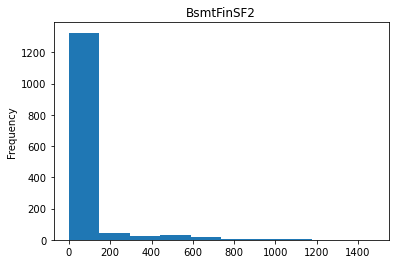

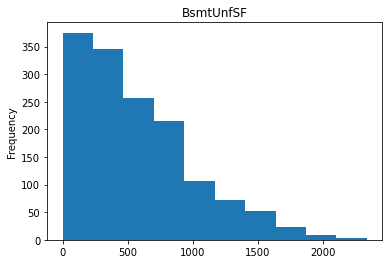

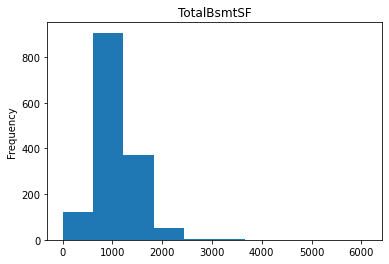

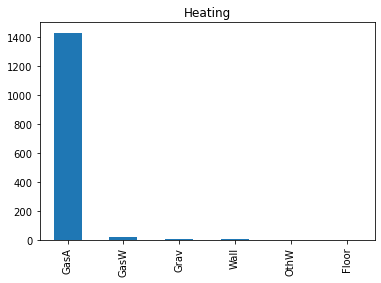

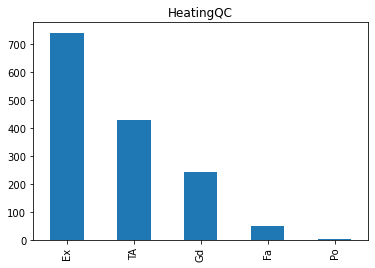

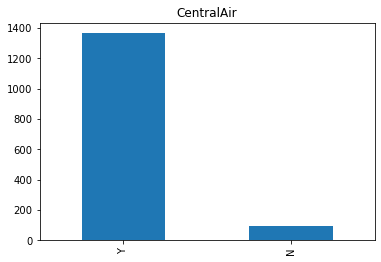

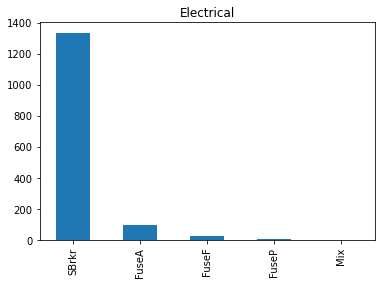

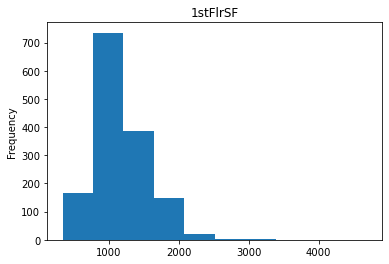

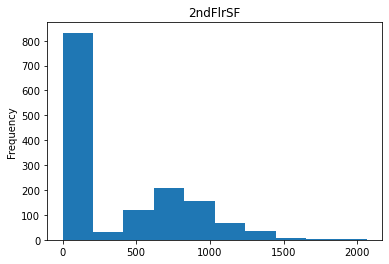

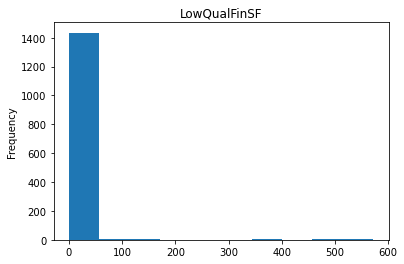

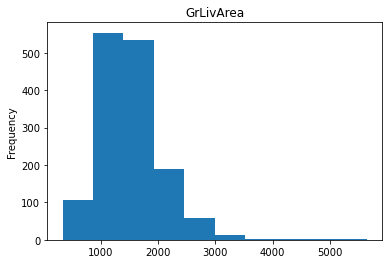

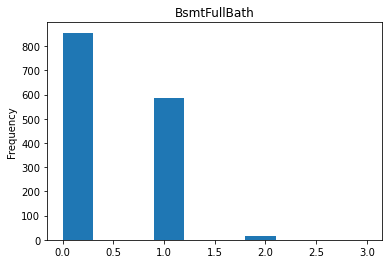

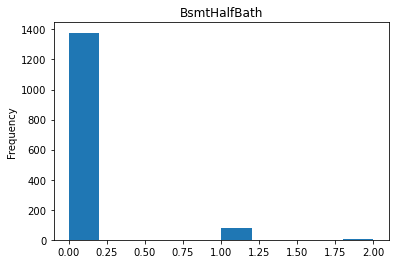

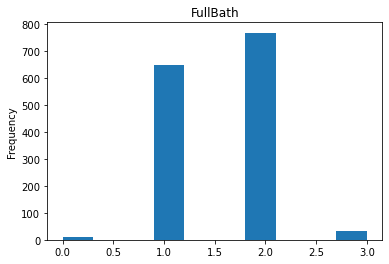

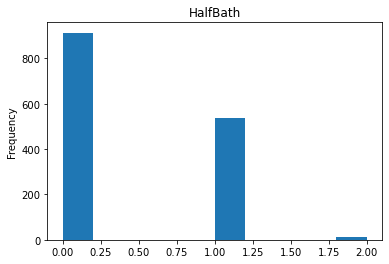

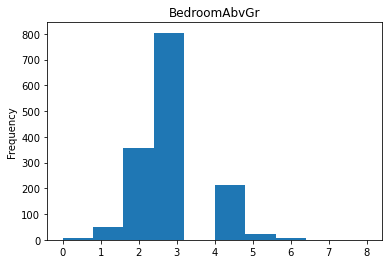

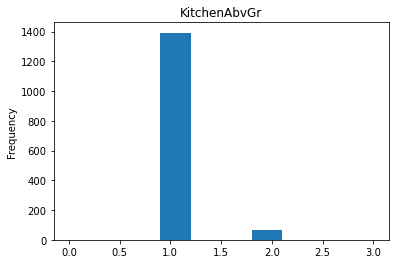

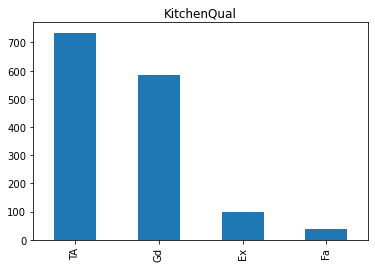

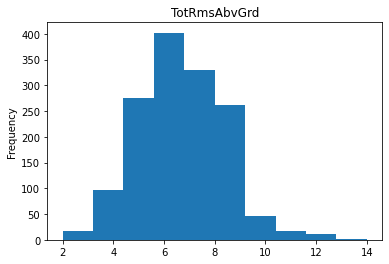

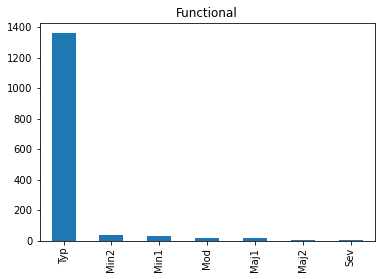

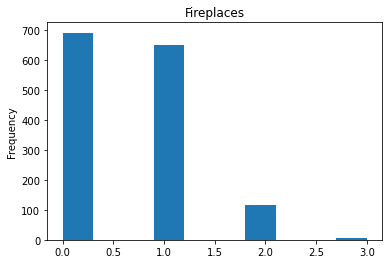

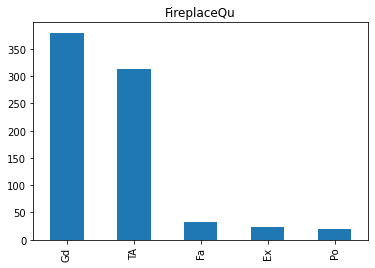

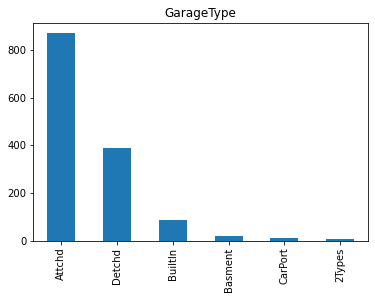

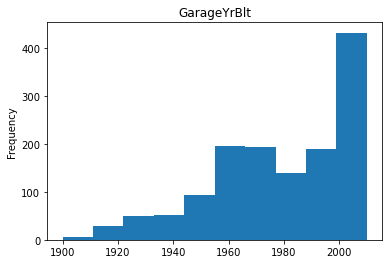

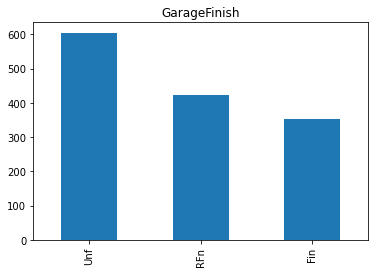

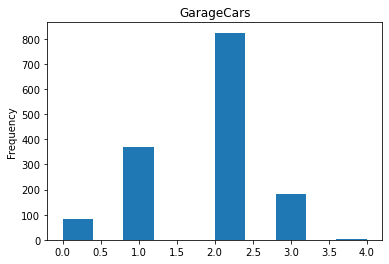

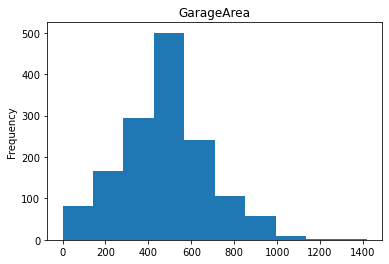

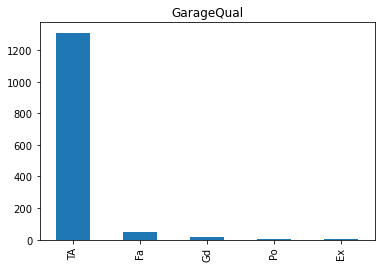

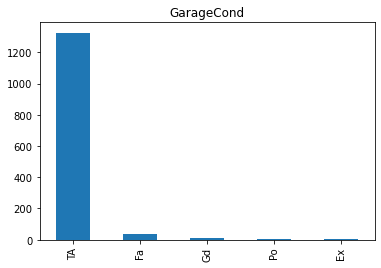

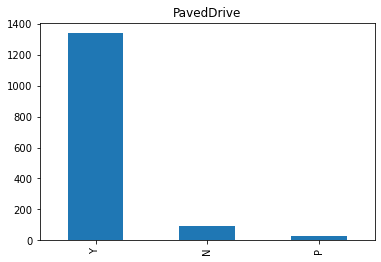

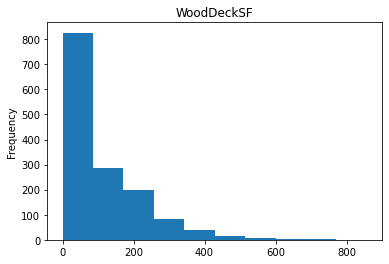

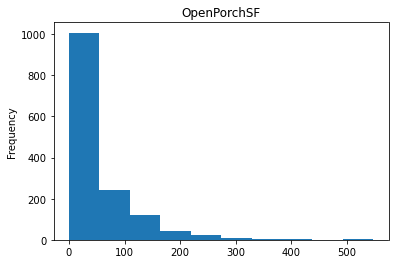

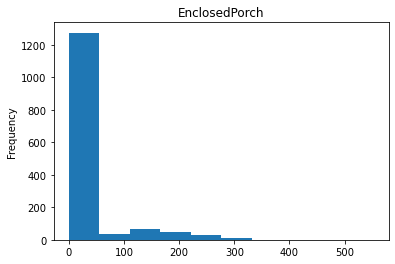

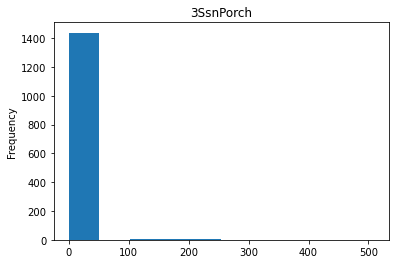

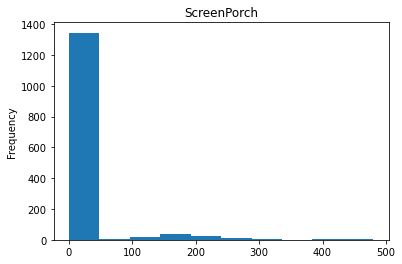

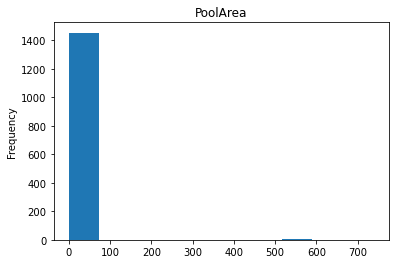

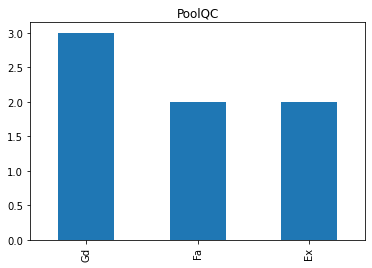

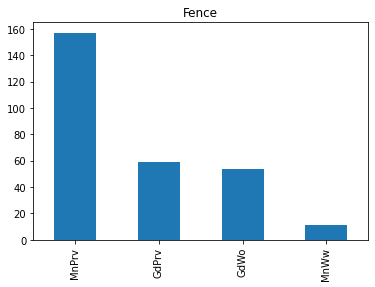

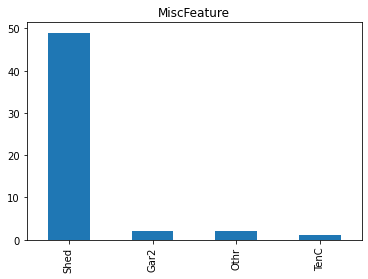

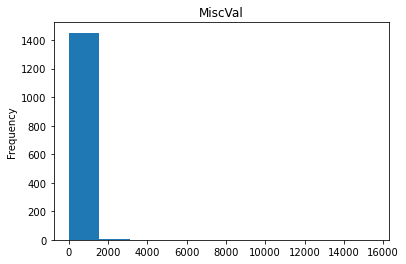

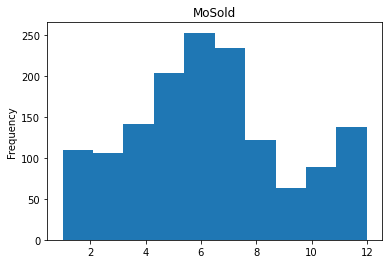

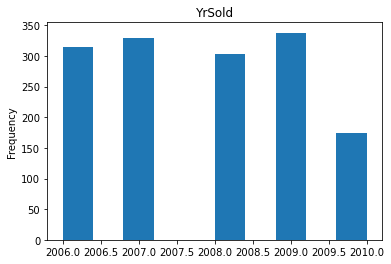

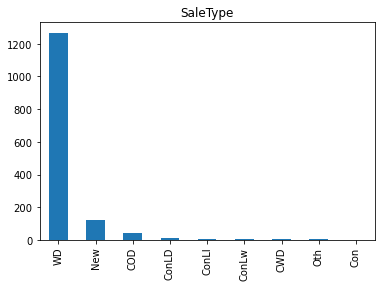

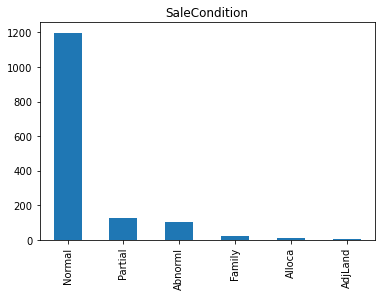

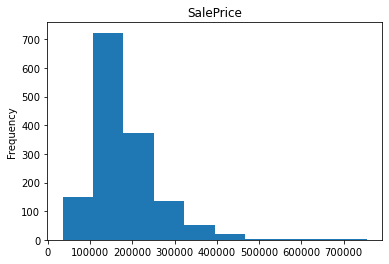

In [6]:
#TODO: gather descriptive statistics to view the range of values in each field. 

#pd.plotting.scatter_matrix(data, alpha = 0.2) <- standard procedure is insufficient for inspecting all fields

for column in data:
    if is_numeric_dtype(data[column]):
        plt.figure(column)
        plt.title(column)
        data[column].plot(kind = 'hist')
    elif is_string_dtype(data[column]):
        plt.figure(column)
        plt.title(column)
        data[column].value_counts()[:10].plot(kind = 'bar')
        
#Check Null values
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()




In [7]:
#TODO: show the frequency of missing values
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

State your observations about the summary statistics and missing values **(in this cell)**:

There are a large number of missing values (almost the entirety of the data set of n=1460) in the fields Alley, PoolQC, Fence, and MiscFeature. Reviewing the data dictionary (data_description.txt), it is apparent that the whomever input the data used NA as an indication that there is no alley, pool, fence, etc. Leaving these missing values will cause our pipeline later on to impute false values, effectively giving some houses fireplaces, garages, pools, alleys, etc. where they are none. Since I am told not to actively fix these problems I will leave them be for now, but they will negatively affect the model.  


Note: recall that not all missing values need to be deleted, some of them can be imputed.

#### The continuous and categorical independent variables
List the continuous and categorical data and state any discrepancy between the number of expected records in the dataset and the `count` that is reported above. 

For the fields that are discussed, view `data_description.txt` which explains the range of values for each field. What does this tell you about these 'missing' values. How do you recommend addressing them? **(You do not need to demonstrate your recommendations)**


In [8]:
continuous_vars = []
for column in data:
    if is_numeric_dtype(data[column]):
        continuous_vars.append(column)
categorical_vars = []
for column in data:
    if is_string_dtype(data[column]):
        categorical_vars.append(column)

In [9]:
dep_var = continuous_vars[-1]
continuous_vars = continuous_vars[0:-1] 

#### The dependent variable
Are there any discrepancies with the dependent variable? Plot a histogram showing its distribution. Is the distribution skewed?

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <BarContainer object of 10 artists>)

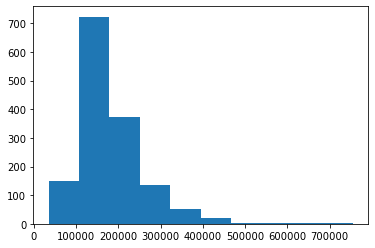

In [10]:
#TODO: Plot the histogram
plt.hist(data[dep_var], bins = 10)
#distribution is skewed to the right

{'whiskers': [<matplotlib.lines.Line2D at 0x22fe9db2640>,
 'caps': [<matplotlib.lines.Line2D at 0x22fe9db2d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x22fe9db22e0>],
 'medians': [<matplotlib.lines.Line2D at 0x22fe9dc4400>],
 'fliers': [<matplotlib.lines.Line2D at 0x22fe9dc4760>],
 'means': []}

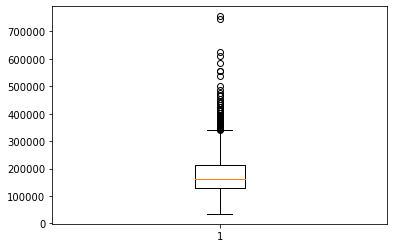

In [11]:
#Are there obvious outliers?

plt.boxplot(data[dep_var])

#Quite a few.

#would it unduly hurt our model to remove the outliers?



{'whiskers': [<matplotlib.lines.Line2D at 0x22fe9e19f10>,
 'caps': [<matplotlib.lines.Line2D at 0x22fe9e27610>,
 'boxes': [<matplotlib.lines.Line2D at 0x22fe9e19bb0>],
 'medians': [<matplotlib.lines.Line2D at 0x22fe9e27cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22fe9e31070>],
 'means': []}

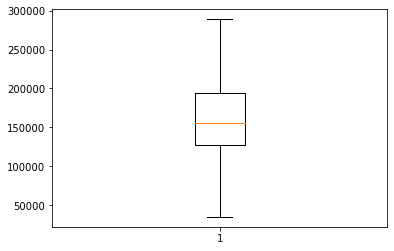

In [12]:
data_rem_outliers = data[data['SalePrice']< 290000]

plt.boxplot(data_rem_outliers[dep_var])

(array([  5.,   9.,  10.,  39.,  48.,  80.,  98., 161., 156., 115., 105.,
        119.,  88.,  52.,  62.,  52.,  45.,  33.,  33.,  24.]),
 array([ 34900.,  47605.,  60310.,  73015.,  85720.,  98425., 111130.,
        123835., 136540., 149245., 161950., 174655., 187360., 200065.,
        212770., 225475., 238180., 250885., 263590., 276295., 289000.]),
 <BarContainer object of 20 artists>)

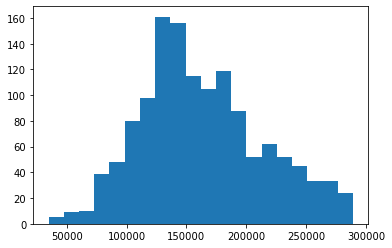

In [13]:
plt.hist(data_rem_outliers[dep_var], bins =20)

## Building the Pipeline
Based on your recommendations above, lets build a pipeline that does the following:
- prepare the data and perform data imputation
- transform the continuous and categorical data (scaling and encoding respectively)
- select the useful features e.g. feature selection, *you can optionally include this in the pipeline or perform this step prior to building the pipeline*
- build, train and evaluate the neural network using Keras.
- perform hyper-parameter tuning using RandomSearchCV **(optional)**
- make predictions with new data

### Step 3 – Data Preparation
Here is some helpful information on [preprocessing and feature extraction pipelines in scikit-learn](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

<span style="color:red">NOTE: You can modify the cell below to suit your needs. However, ensure that the preprocessing steps that you perform is done in the data frame e.g. `data` </span>

In [14]:
print(continuous_vars)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [15]:
#impute missing continuous values with the median and scale the data

continuous_features  = continuous_vars #TODO: provide a list of continuous fields that will be used in the model(except the dependent variable)
continous_transformer = Pipeline(
    steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
    ])

#impute the NA categorical values and encode the data

categorical_features = categorical_vars #TODO: provide a list of categorical fields that will be used in the model
categorical_transformer = Pipeline(
    steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'NotApp')), #Use an alternative value to indicate NA in the dataset
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ])

data_preprocessor   = ColumnTransformer(
    transformers = [
        ('continuous', continous_transformer, continuous_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

#NOTE: the steps above will not be performed until we call `fit_transform` (in the next cell).


### Step 4 – Data Transformation & Feature Selection
Here is some helpful information on [feature selection as part of a pipeline](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-as-part-of-a-pipeline). If you add a feature selection algorithm to the pipeline, ensure that it supports regression.

In [16]:
data.iloc[:, 1:-1]

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [17]:
data_prep_pipeline  = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    #This performs the data preparation steps in the cell above
    ('feature_selection', SelectKBest(score_func=f_regression, k =5))  #TODO: identify a feature selection algorithm or exclude this line if you have previously performed feature selection on the data.
    ])

transformed_data = data_prep_pipeline.fit_transform(data.iloc[:, :-1], data['SalePrice']) #transform the data


In [18]:
transformed_data = transformed_data.toarray()

### Step 5 – Building the Model
#### Build the neural network using Keras
Build a feed forward neural network with: an input layer, hidden layers and one output layer. 

Note: you are required to provide a suitable [optimizer](https://keras.io/api/optimizers/) and [loss function](https://keras.io/api/losses/) for the regression task. Optimizers include: 'Adam', 'SGD' and RMSprop. Loss functions include: 'mean_squared_error', 'mean_squared_logarithmic_error', 'mean_absolute_error'

In [19]:
X = transformed_data #this is the transformed data from the pipeline
y = data['SalePrice'] #this is the output

In [20]:
type(X)

numpy.ndarray

In [22]:


#Build a sequential model with at least three dense layers (you can add more layers as needed)
#Note: you can also add this keras model to the data preprocessing pipeline but we can skip that step for now.
ffnn_model = Sequential()
ffnn_model.add(Dense(1000, activation='relu', input_shape=(X.shape[1],))) #X.shape[1] is the number of selected features 
ffnn_model.add(Dense(1000, activation='relu'))
ffnn_model.add(Dense(500, activation='relu'))
ffnn_model.add(Dense(250, activation='relu'))
ffnn_model.add(Dense(125, activation='relu'))
#TODO: Add the output layer
ffnn_model.add(Dense(1, activation = 'relu'))
ffnn_model.compile(optimizer= 'Adam' , #TODO: state the optimize
                   loss= 'mean_absolute_error',      #TODO: state the loss function
                   metrics= 'mae'     #TODO: state the metric 
                                             #make sure this is regression appropriate
                  )

ffnn_history = ffnn_model.fit(X, y, 
                              validation_split= 0.25, #TODO: state the validation split
                              epochs= 20, #TODO: state the number of epochs (you may need to run the model a few times to find a suitable value)
                              batch_size= 100, #TODO: state the number of observations to use in each batch
                              verbose=1)


Epoch 1/20
11/11 [==============================] - 0s 36ms/step - loss: 181375.0625 - mae: 181375.0625 - val_loss: 179436.5625 - val_mae: 179436.5625
Epoch 2/20
11/11 [==============================] - 0s 14ms/step - loss: 180760.4062 - mae: 180760.4062 - val_loss: 177190.4375 - val_mae: 177190.4375
Epoch 3/20
11/11 [==============================] - 0s 14ms/step - loss: 172803.2344 - mae: 172803.2344 - val_loss: 155181.6719 - val_mae: 155181.6719
Epoch 4/20
11/11 [==============================] - 0s 14ms/step - loss: 124289.9844 - mae: 124290.0000 - val_loss: 78232.1875 - val_mae: 78232.1875
Epoch 5/20
11/11 [==============================] - 0s 14ms/step - loss: 73868.9922 - mae: 73868.9922 - val_loss: 60664.4258 - val_mae: 60664.4258
Epoch 6/20
11/11 [==============================] - 0s 14ms/step - loss: 55090.8750 - mae: 55090.8750 - val_loss: 50899.9844 - val_mae: 50899.9844
Epoch 7/20
11/11 [==============================] - 0s 16ms/step - loss: 42947.3242 - mae: 42947.3242 - 

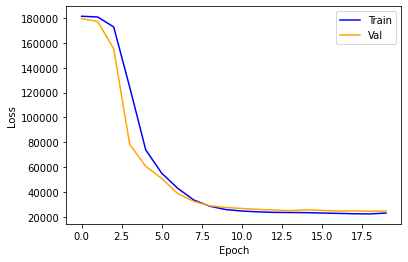

In [23]:
# Visualize the training and validation loss
plt.plot(ffnn_history.history['loss'], 'b', ffnn_history.history['val_loss'], 'orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Let's use the neural network to make predictions!

In [24]:
ffnn_model

#### Load the test data

In [25]:
#TODO: Load the data from `house_prices_test.csv`
test_data_url = 'house_prices_test.csv'
test_data = pd.read_csv(test_data_url)

del test_data['Id']

#### Prepare the test data using the pipeline
This will impute any missing values and scale/encode the fields.

In [26]:
prep_test_data = data_prep_pipeline.transform(test_data)

#### Use the neural network to make predictions

In [27]:
result = ffnn_model.predict(prep_test_data #TODO: provide the preprocessed test data (above)
        )


In [28]:
pd.set_option('display.max_columns', None)
test_data['Predicted_Sales_Price'] = result
test_data.head()




,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Predicted_Sales_Price
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,125712.109375
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,149137.375000
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,143174.625000
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,162682.312500
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,203390.375000


## Summary
Display samples of the predictions from your model and summarize your thoughts on the model's performance, the training process and its ability to generalize with new data. What are your recommendations to improve the model in the future?

Model seems to be working. Values outputted make sense. training and validation curves appear to converge at an average error of plus or minus 30,000 dollars, which seems fairly accurate. Validation is appropriately less accurate than training (indicating I haven't overtrained the model). One could probably enhance this model with some more rigorous feature selection/engineering, more appropriate responses to the null values, and of course more data. 